# Анализ оттока клиентов телекоммуникационной компании "ТелеДом"

Целью данной работы является создание модели предсказывающей отток существующих пользователей в пользу других телекоммуникационных компаний. На основе предсказаний модели абонентам планирующим отказаться от услуг связи будут предложены более выгодные условия отделом маркетинга. В нашем распоряжении данные о выборке клиентов и услугах находящихся в 4х таблицах: 

contract_new.csv — информация о договоре;
personal_new.csv — персональные данные клиента;
internet_new.csv — информация об интернет-услугах;
phone_new.csv    — информация об услугах телефонии.


In [1]:
# !pip install --upgrade pip -q
# !pip install --upgrade scikit-learn -q
# !pip install seaborn -q
# !pip install lightgbm -q
# !pip install shap -q
# !pip install phik

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from lightgbm import LGBMClassifier
import shap
import phik

## Загрузка данных

In [3]:
try:
    contract_new = pd.read_csv('contract_new.csv')
    personal_new = pd.read_csv('personal_new.csv')
    internet_new = pd.read_csv('internet_new.csv')
    phone_new    = pd.read_csv('phone_new.csv')
except FileNotFoundError:
    contract_new = pd.read_csv('####')
    personal_new = pd.read_csv('####')
    internet_new = pd.read_csv('####')
    phone_new    = pd.read_csv('####')

## Исследовательский анализ данных и предобработка данных

In [4]:
display(contract_new.head())
contract_new.info()
print('contract_new shape', contract_new.shape)
display(contract_new.describe())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
contract_new shape (7043, 8)


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


Файл __contract_new__, __расшифровка столбцов__:
customerID — идентификатор абонента;
BeginDate — дата начала действия договора;
EndDate — дата окончания действия договора;
Type — тип оплаты: раз в год-два или ежемесячно;
PaperlessBilling — электронный расчётный лист;
PaymentMethod — тип платежа;
MonthlyCharges — расходы за месяц;
TotalCharges — общие расходы абонента.

Из общей информации о датасете видно, что пропущенных значений нет. Также видно, что типы данных для нескольких столбцы определились не правильно, приведём их к соотвествующему виду.

In [5]:
def convert_to_datetime(X):
    X['BeginDate'] = pd.to_datetime(X['BeginDate'], format='%Y-%m-%d')
    X['EndDate'] = pd.to_datetime(X['EndDate'], errors='coerce', format='%Y-%m-%d')
    return X

def convert_to_numeric(X):
    X['TotalCharges'] = pd.to_numeric(X['TotalCharges'], errors='coerce')
    # Вообще столбец MonthlyCharges нормальный сразу, но для полноты добавим конвертацию
    X['MonthlyCharges'] = pd.to_numeric(X['MonthlyCharges'], errors='coerce')
    return X

pipeline = Pipeline(steps=[
    ('to_datetime', FunctionTransformer(convert_to_datetime)),
    ('to_numeric', FunctionTransformer(convert_to_numeric))
])

contract_new_transformed = pipeline.fit_transform(contract_new)
contract_new_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


Из кода выше видно, что в данных образовались пропуски, это столбцы EndDate, где заполнено всего 1101 дат, он же является целевым и столбец TotalCharges в котором не хватает 11 значений. Пропуск в столбце EndDate означает что абонент остаётся с компанией, датами обозначены даты ухода абонентов. Посмотрим на пропущенные значения столбца TotalCharges.

In [6]:
display(tot_charges_na := contract_new_transformed[contract_new_transformed.TotalCharges.isna()])
print('Количество строк где TotalCharges = NA', tot_charges_na.shape)
contract_new_transformed[contract_new_transformed.BeginDate == contract_new_transformed.BeginDate.max()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN


Количество строк где TotalCharges = NA (11, 8)


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN


Найдём максимальную дату у всего датасета и вытащим все строки с ней. Сравним индексы с датафреймом отфильтрованным по TotalCharges = NA и увидим что они равны. Вывод: абоненты только подключились и столбец TotalCharges ещё не обновился, возможно он обновиться когда провайдер получит первый платёж от новых абонентов. 

In [7]:
# Заменим NA на 0
contract_new_transformed.loc[contract_new_transformed.TotalCharges.isna(), 'TotalCharges'] = 0

Посмотрим на графики распределения и гистограммы.

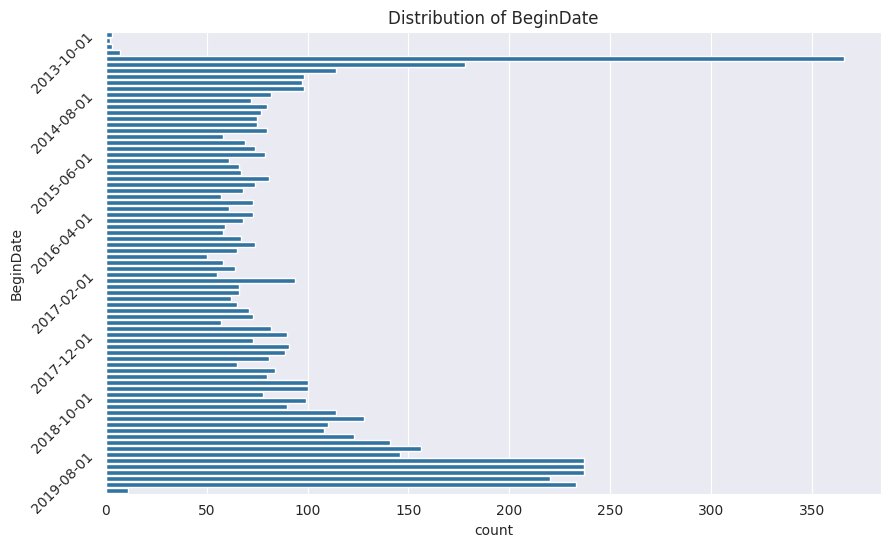

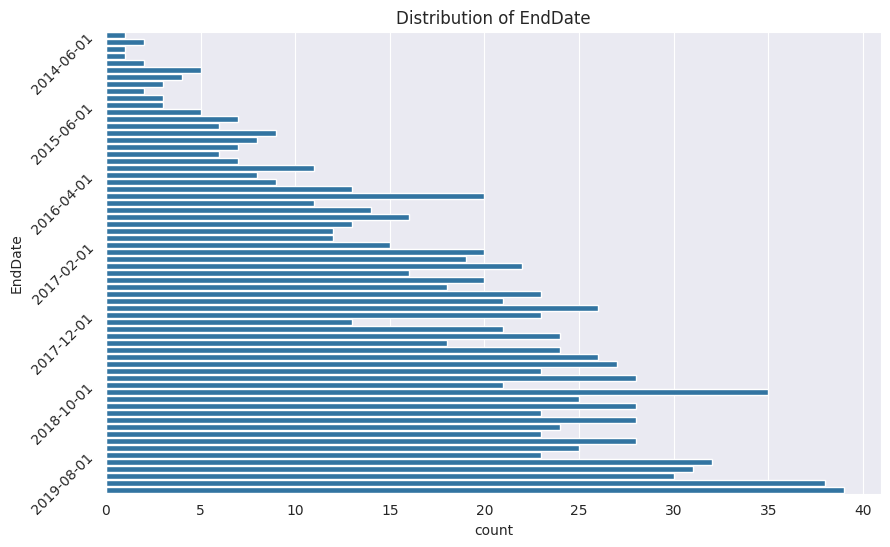

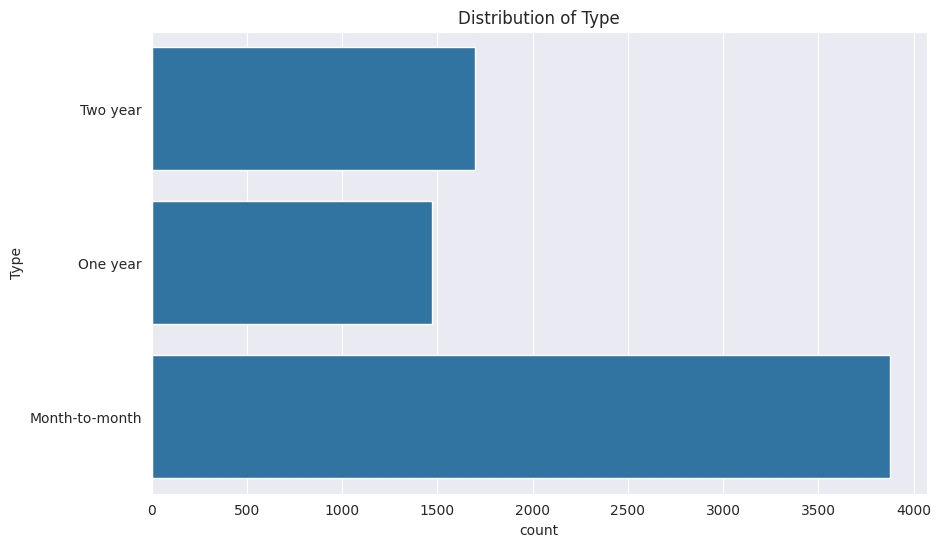

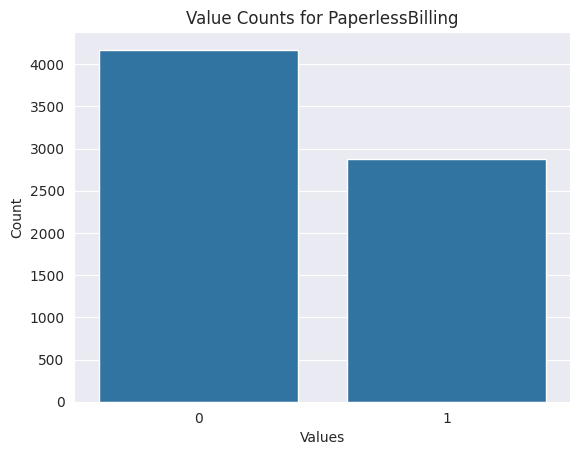

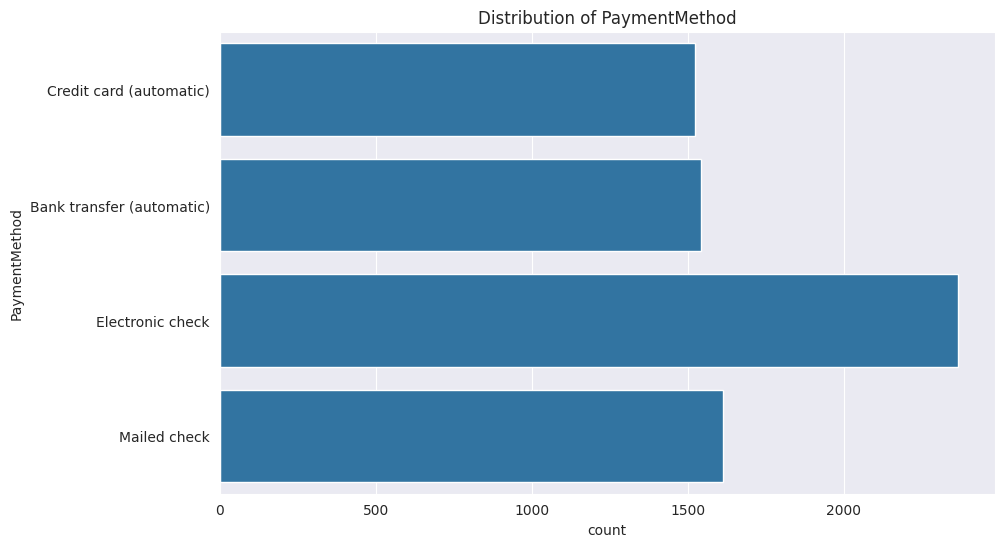

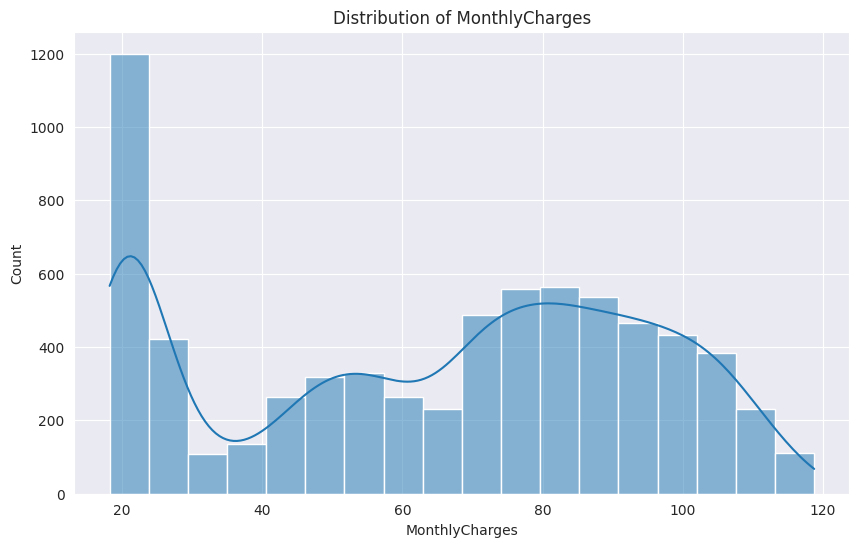

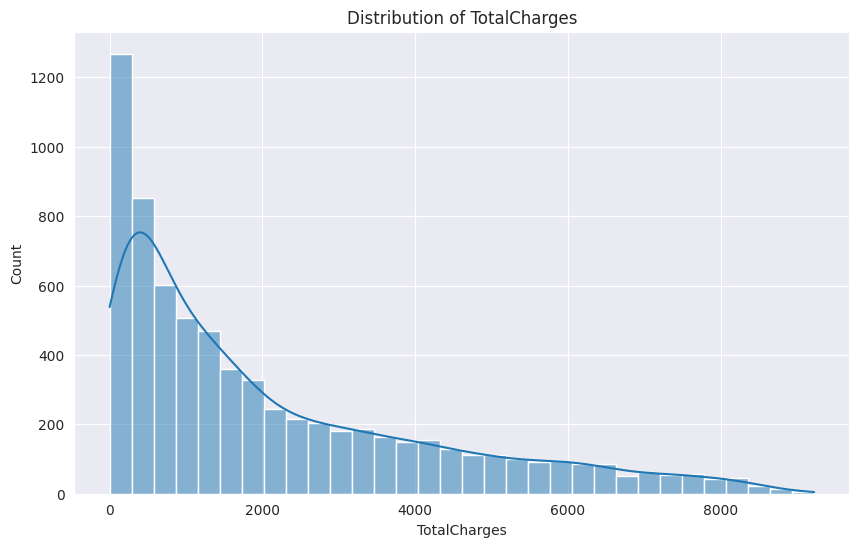

In [8]:
for column in contract_new_transformed.columns:
    if column == 'customerID':
        continue
    if column.startswith('Paperless'):
        sns.countplot(x=contract_new_transformed[column])
        plt.title(f'Value Counts for {column}')
        plt.xlabel('Values')
        plt.ylabel('Count')
        plt.xticks([0, 1], ['0', '1'])
        plt.show()
        continue
    plt.figure(figsize=(10, 6))
    plt.title(f'Distribution of {column}')

    if pd.api.types.is_numeric_dtype(contract_new_transformed[column]):
        sns.histplot(contract_new_transformed[column], kde=True)
    else:
        if 'Date' in column:
            contract_new_transformed = contract_new_transformed.sort_values(column)
            sns.countplot(y=column, data=contract_new_transformed)
            ax = plt.gca()
            ticks = ax.get_yticks()
            tick_labels = ax.get_yticklabels()
            ax.set_yticks(ticks[::10])
            ax.set_yticklabels(tick_labels[::10], rotation=45)
        else:
            sns.countplot(y=column, data=contract_new_transformed)

    plt.show()

Из графиков видно, что у компании были проблемы с привлечением новых абонентов, однако в 2018-2019 годах ситуация исправилась. Одновременно с этим количество уходящих абонентов стабильно растёт. Клиенты предпочитают заключать помесячные контракты, большая часть клиентов предпочитает электронный биллинг. Также большая часть клиентов платят при помощи электронных чеков. Остальные формы платежей находятся на примерно одинаковом уровне. Электронные чеки значительно опережают такие формы платежей как автоматические списания и чеки по почте. Распределения столбцов MonthlyCharges и TotalCharges не нормальные, со значительным перекосом влево. Это показатель того что большинство клиентов платят небольшие суммы.

Рассмотрим следующую таблицу из задания.

In [9]:
display(personal_new.head())
personal_new.info()
print('personal_new shape', personal_new.shape)
display(personal_new.describe())

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
personal_new shape (7043, 5)


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Таблица __personal_new__, __описание столбцов__:
customerID — идентификатор пользователя;
gender — пол;
SeniorCitizen — является ли абонент пенсионером;
Partner — есть ли у абонента супруг или супруга;
Dependents — есть ли у абонента дети.

Посмотрим как различаются классы значений.

In [10]:
personal_new

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


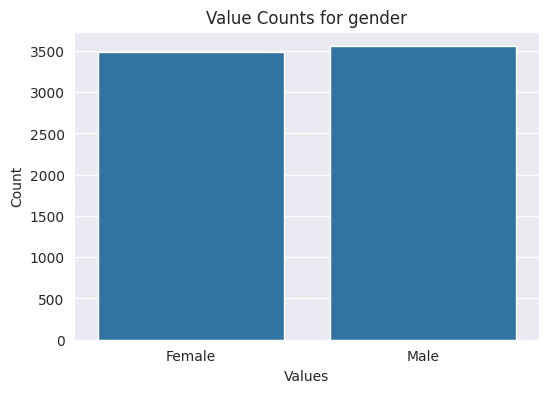

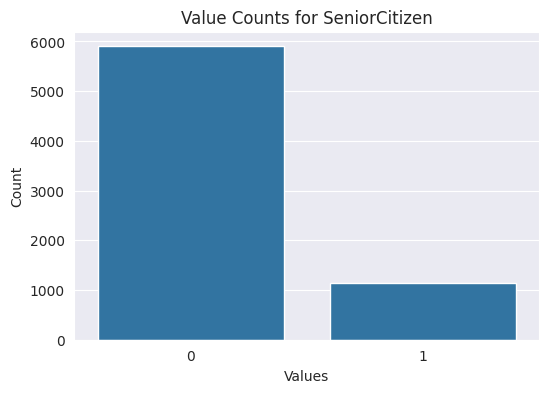

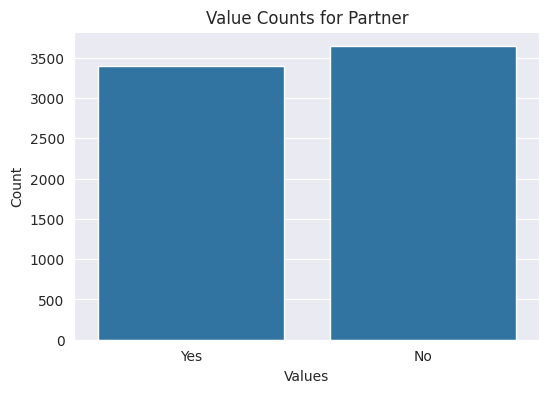

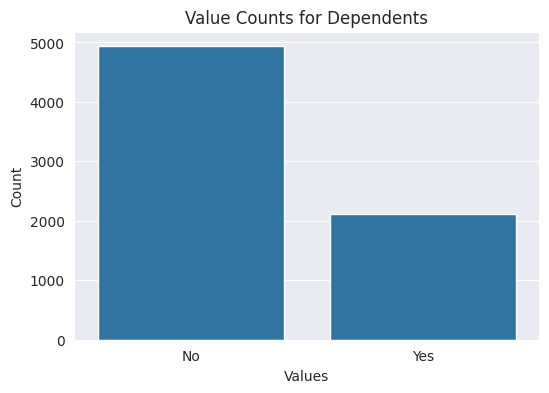

In [11]:
for col in personal_new.columns[1:]:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=personal_new[col])
    plt.title(f'Value Counts for {col}')
    plt.xlabel('Values')
    plt.ylabel('Count')
    plt.show()

Из графиков видно, что пенсионеров в 6 раз меньше чем обычных абонентов. Количество людей у которых есть партнер немного меньше чем количество холостых. Людей с наличием зависимых от них в 2 раза меньше чем людей свободных от подобных обязанностей. Количество мужчин и женщин примерно одинаково.

Перейдём к таблице __internet_new__, __описание столбцов__:
customerID — идентификатор пользователя;
InternetService — тип подключения;
OnlineSecurity — блокировка опасных сайтов;
OnlineBackup — облачное хранилище файлов для резервного копирования данных;
DeviceProtection — антивирус;
TechSupport — выделенная линия технической поддержки;
StreamingTV — стриминговое телевидение;
StreamingMovies — каталог фильмов.

In [12]:
display(internet_new.head())
internet_new.info()
print('internet_new shape', internet_new.shape)
display(internet_new.describe())

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
internet_new shape (5517, 8)


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Построим столбчатые диаграммы для оценки распределения.

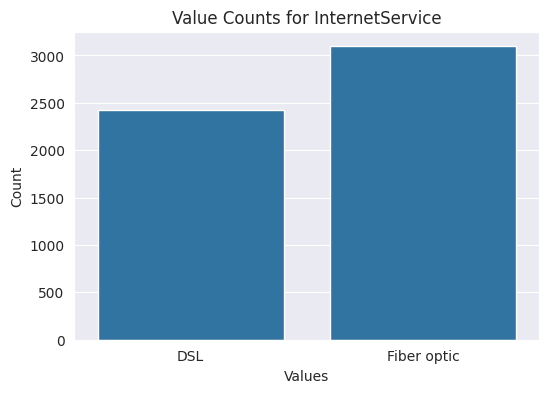

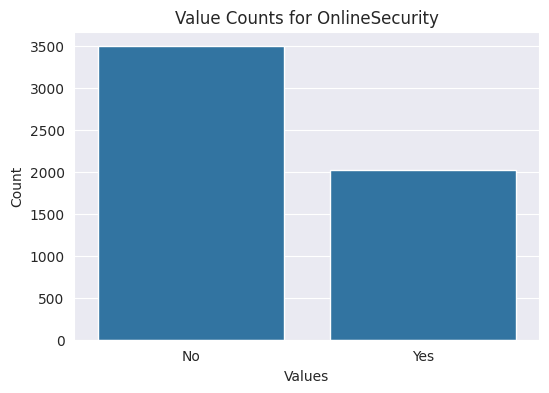

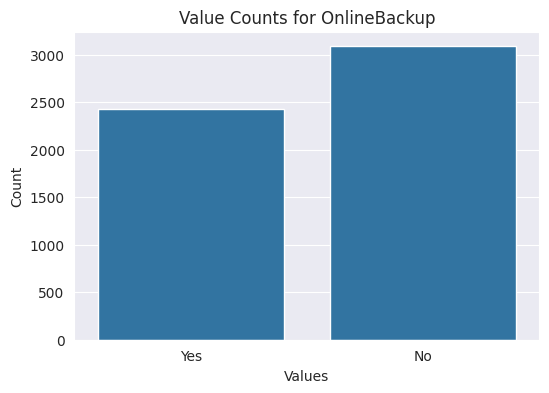

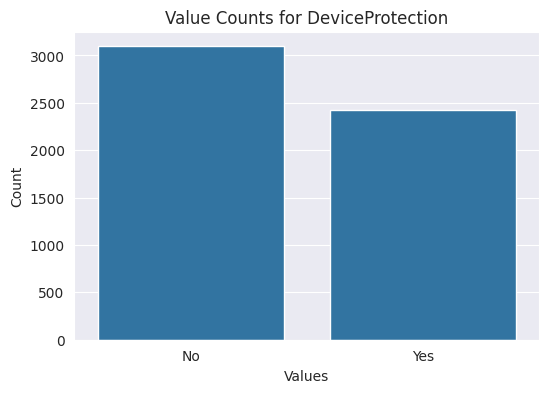

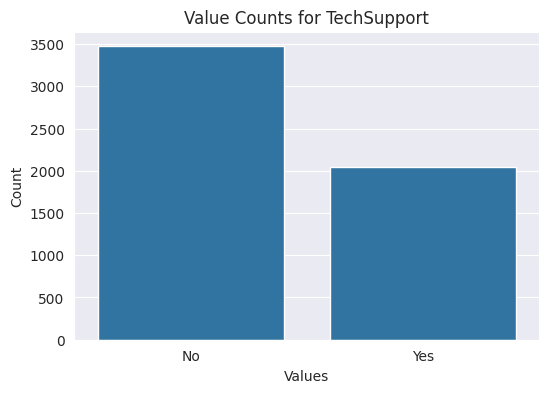

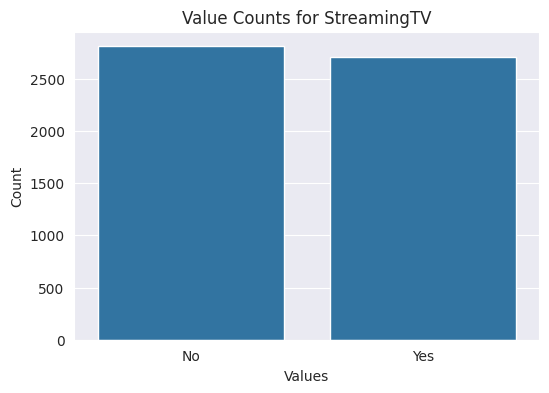

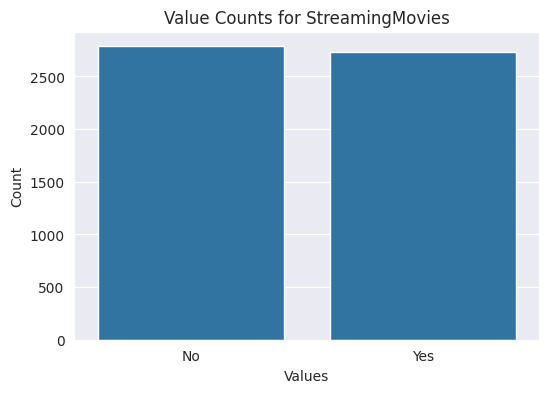

In [13]:
for col in internet_new.columns[1:]:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=internet_new[col])
    plt.title(f'Value Counts for {col}')
    plt.xlabel('Values')
    plt.ylabel('Count')
    plt.show()

Количество пользователей на оптоволокне больше чем пользователей на DSL. Число людей у которых не установлен блокировщик опасных сайтов значительно больше чем тех у кого установлен. Большая часть людей не пользуется услугами резервного копирования, антивирусом и выделенной линией технической поддержки. Услугами стриминг телевидения и каталогом фильмов пользуется примерно равно количество людей в каждой из групп(тех кто пользуется и не пользуется).

Взглянем на людей которые не пользуются услугами интернета:

In [14]:
no_internet = set(contract_new_transformed.customerID) - set(internet_new.customerID)
contract_new_transformed[contract_new_transformed.customerID.isin(no_internet)]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
269,7014-ZZXAW,2014-03-01,2014-06-01,Two year,Yes,Credit card (automatic),24.25,77.84
2980,5598-IKHQQ,2014-02-01,2015-01-01,Two year,No,Credit card (automatic),25.45,293.95
2524,0784-ZQJZX,2014-02-01,2015-03-01,Two year,No,Credit card (automatic),19.90,258.70
4505,6917-FIJHC,2014-02-01,2015-03-01,Two year,Yes,Mailed check,26.00,341.38
3724,5201-CBWYG,2014-12-01,2015-04-01,One year,No,Bank transfer (automatic),24.80,100.19
...,...,...,...,...,...,...,...,...
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,0.00
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,0.00
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,0.00
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,0.00


Наконец рассмотрим четвёртую таблицу __phone_new__, __описание столбцов__:
customerID — идентификатор пользователя;
MultipleLines — подключение телефона к нескольким линиям одновременно.
Всего один столбец, помимо идентификатора клиента.

In [15]:
display(phone_new.head())
phone_new.info()
print('phone_new shape', phone_new.shape)
display(phone_new.describe())

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
phone_new shape (6361, 2)


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


Пропусков в данных нет.

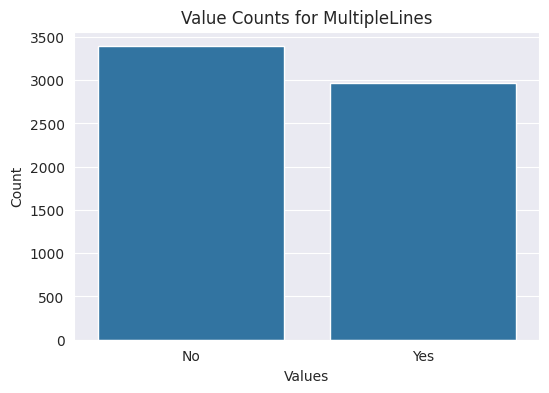

In [16]:
plt.figure(figsize=(6, 4))
sns.countplot(x=phone_new[f'{phone_new.columns[1]}'])
plt.title(f'Value Counts for {phone_new.columns[1]}')
plt.xlabel('Values')
plt.ylabel('Count');

Неожиданно, но количество абонентов у которых подключено несколько линий к одному телефону не сильно меньше чем тех у кого только одна линия на телефоне.

Проверим все таблицы на дубликаты и за одно посмотрим на названия столбцов после перекодирования:

In [17]:
display(contract_new_transformed[contract_new_transformed.duplicated()])
display(personal_new[personal_new.duplicated()])
display(internet_new[internet_new.duplicated()])
display(phone_new[phone_new.duplicated()])

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


,customerID,gender,SeniorCitizen,Partner,Dependents


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies


,customerID,MultipleLines


Дублей в исходных таблицах нет.

__Вывод__: Данные проверены на наличие дублей и пропущенных значений.

## Объединение данных

In [18]:
merged_df = pd.merge(contract_new_transformed, personal_new, 
                     on='customerID', how='left')
merged_df = pd.merge(merged_df, internet_new, 
                     on='customerID', how='left')
merged_df = pd.merge(merged_df, phone_new, 
                     on='customerID', how='left')
merged_df.shape

(7043, 20)

## Исследовательский анализ и предобработка данных объединённого датафрейма

Рассчитаем процент пропущенных значений по столбцам.

In [19]:
na_percentage = (merged_df.isna().sum() / len(merged_df)) * 100
display(na_percentage[:11])
display(na_percentage[11:])

customerID           0.000000
BeginDate            0.000000
EndDate             84.367457
Type                 0.000000
PaperlessBilling     0.000000
PaymentMethod        0.000000
MonthlyCharges       0.000000
TotalCharges         0.000000
gender               0.000000
SeniorCitizen        0.000000
Partner              0.000000
dtype: float64

Dependents           0.000000
InternetService     21.666903
OnlineSecurity      21.666903
OnlineBackup        21.666903
DeviceProtection    21.666903
TechSupport         21.666903
StreamingTV         21.666903
StreamingMovies     21.666903
MultipleLines        9.683374
dtype: float64

Есть пропущенные значения в нескольких столбцах: EndDate, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines. Похоже, что основной виновник это таблица internet_new. По столбцу EndDate всё понятно, там пропущенное значение это целевой признак(клиент остался в компании). В таблице phone_new тоже не хватает части данных.

In [20]:
def replace_na_in_internet_service(merged_df):
    merged_df.loc[merged_df.InternetService.isna(), 'InternetService'] = 'NoService'
    return merged_df

def fix_the_rest(merged_df):
    merged_df.loc[merged_df.InternetService == 'NoService', 'OnlineSecurity':'StreamingMovies'] = 'NoService'
    return merged_df
    
merged_df = fix_the_rest(replace_na_in_internet_service(merged_df))

Заполняем пропуски в столбце multiple_lines.

In [21]:
for col in merged_df.columns:
    print(merged_df[merged_df.MultipleLines.isna()][col].value_counts())

customerID
8780-YRMTT    1
9796-MVYXX    1
6834-NXDCA    1
2834-JKOOW    1
0601-WZHJF    1
             ..
9060-HJJRW    1
7740-KKCXF    1
2625-TRCZQ    1
8582-KRHPJ    1
1371-DWPAZ    1
Name: count, Length: 682, dtype: int64
BeginDate
2019-10-01    33
2014-02-01    31
2019-11-01    29
2019-09-01    23
2019-07-01    20
              ..
2015-07-01     2
2016-12-01     2
2020-02-01     2
2014-01-01     1
2017-11-01     1
Name: count, Length: 74, dtype: int64
EndDate
2019-09-01    6
2017-06-01    5
2019-12-01    5
2020-01-01    4
2018-11-01    4
2018-09-01    4
2018-08-01    4
2017-11-01    4
2018-12-01    3
2018-07-01    3
2017-10-01    3
2017-12-01    3
2016-10-01    3
2016-11-01    2
2018-06-01    2
2019-11-01    2
2019-10-01    2
2019-07-01    2
2019-05-01    2
2019-04-01    2
2019-03-01    2
2015-12-01    2
2018-10-01    2
2016-05-01    2
2016-12-01    2
2015-01-01    2
2015-02-01    2
2016-07-01    2
2016-09-01    2
2017-08-01    2
2017-07-01    2
2018-04-01    1
2019-06-01    1
201

Пропуск имеет корреляцию со столбцом InternetService и всегда соответствуют значению DSL, поэтому введём для него третью специальную категорию missing_DSL, что-бы не потерять информацию.

In [22]:
value_to_impute = 'missing_DSL'
condition = merged_df['InternetService'] == 'DSL'
merged_df.loc[condition, 'MultipleLines'] = merged_df.loc[condition, 'MultipleLines'].fillna(value_to_impute)

In [23]:
print(max(merged_df.BeginDate), max(merged_df.EndDate),
      min(merged_df.BeginDate), min(merged_df.EndDate))

date_diff = merged_df.EndDate - merged_df.BeginDate
rows_with_na = merged_df.loc[date_diff.isna()]
date_diff[date_diff.isna()] = pd.to_datetime('2020-02-01', format='%Y-%m-%d') - rows_with_na.BeginDate
merged_df['date_diff'] = date_diff.dt.days

2020-02-01 00:00:00 2020-01-01 00:00:00 2013-10-01 00:00:00 2014-06-01 00:00:00


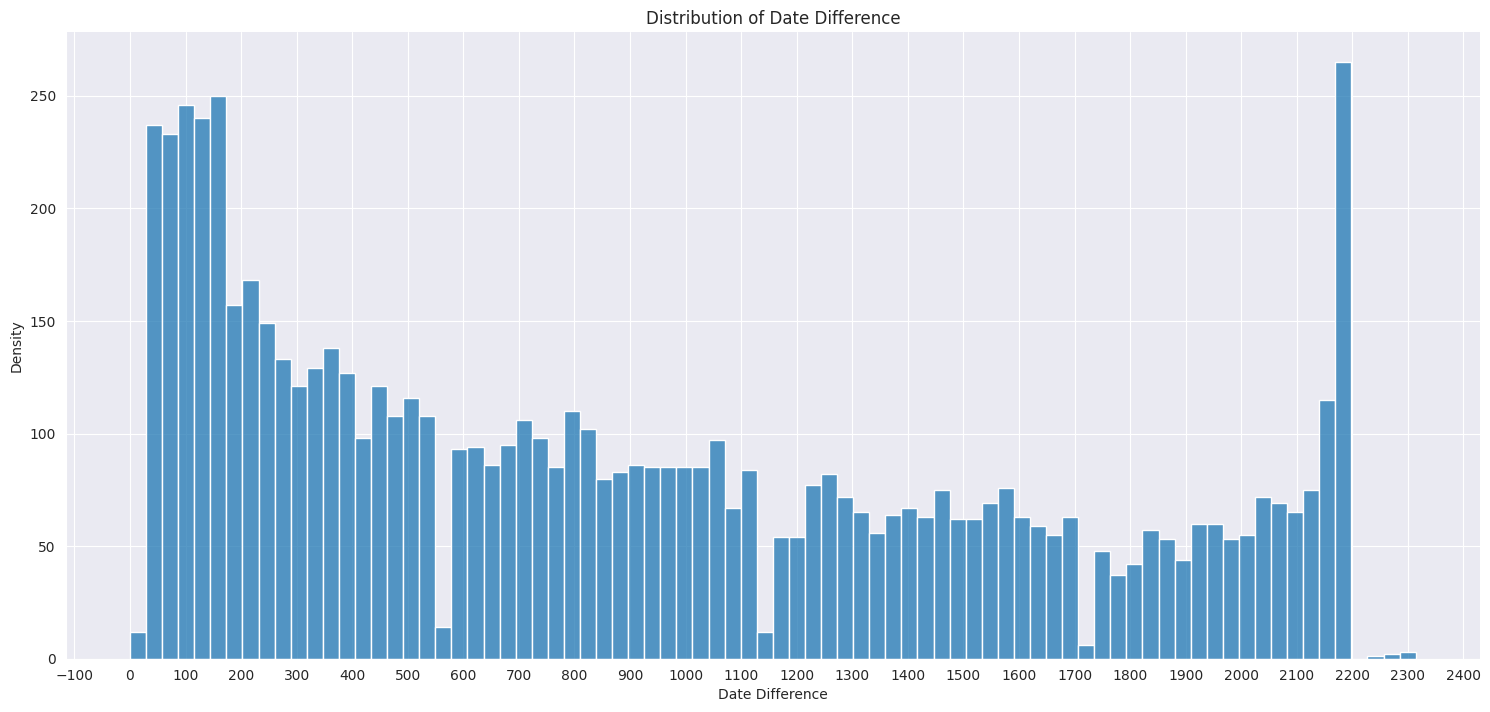

In [24]:
g = sns.displot(merged_df['date_diff'], bins=80, height=7, aspect=15/7)

plt.title('Distribution of Date Difference')
plt.xlabel('Date Difference')
plt.ylabel('Density')
g.ax.xaxis.set_major_locator(ticker.MultipleLocator(base=100))
plt.show()

Распределение очень похоже на распределение по дате регистрации, но в обратном порядке. Чего нет в графике по дате регистрации так это сильных просадок по плотности почти каждые 2 года. Скорее всего это как-то связано с двухлетними контрактами. У меня нет идей.

In [25]:
# Создадим целевой столбец, который показывает расторгнут или нет договор с компанией
merged_df['is_subscriber'] = merged_df.EndDate.isna().astype(int)

In [26]:
merged_df = merged_df.drop(['BeginDate', 'EndDate', 'customerID'], axis=1)
merged_df

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,date_diff,is_subscriber
0,Two year,Yes,Credit card (automatic),24.25,77.84,Female,0,Yes,No,NoService,NoService,NoService,NoService,NoService,NoService,NoService,Yes,92,0
1,Two year,Yes,Bank transfer (automatic),105.65,228.20,Female,0,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,62,0
2,Two year,Yes,Bank transfer (automatic),93.05,677.40,Male,1,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,No,No,Yes,212,0
3,One year,No,Electronic check,104.10,637.09,Male,0,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,183,0
4,Two year,Yes,Bank transfer (automatic),114.20,1281.32,Female,0,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,335,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Two year,No,Mailed check,19.85,0.00,Male,0,Yes,Yes,NoService,NoService,NoService,NoService,NoService,NoService,NoService,No,0,1
7039,Two year,No,Mailed check,73.35,0.00,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0,1
7040,Two year,No,Mailed check,80.85,0.00,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0,1
7041,Two year,No,Mailed check,25.35,0.00,Male,0,Yes,Yes,NoService,NoService,NoService,NoService,NoService,NoService,NoService,Yes,0,1


В коде выше было создано 2 новых столбца, разница в днях между 1 января 2020 года и датой подписания договора, первая дата была выбрана исходя из того что это верхняя граница данных. По логике чем дольше клиент был в компании и соответственно чем больше количество дней в колонке, тем он лояльнее к компании. И вторая колонка бинарный классификатор является ли клиент активным подписчиком на услуги или он уже расторг договор, этот столбец теперь является целевым. Столбцы с датами были удалены что-бы не усложнять модель.

Посмотрим на данные

In [27]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   gender            7043 non-null   object 
 6   SeniorCitizen     7043 non-null   int64  
 7   Partner           7043 non-null   object 
 8   Dependents        7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  MultipleLines     7043 non-null   object 


In [28]:
# Столбцы is_subscriber и SeniorCititzen требуют конвертации
merged_df['SeniorCitizen'] = merged_df['SeniorCitizen'].astype('category')
merged_df['is_subscriber'] = merged_df['is_subscriber'].astype('category')

Проведём EDA

пропущенные значения
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
date_diff           0
is_subscriber       0
dtype: int64
Описательная статистика для числовых переменных
       MonthlyCharges  TotalCharges    date_diff
count     7043.000000   7043.000000  7043.000000
mean        64.761692   2115.312885   898.555729
std         30.090047   2112.742814   683.130510
min         18.250000      0.000000     0.000000
25%         35.500000    436.750000   276.000000
50%         70.350000   1343.350000   761.000000
75%         89.850000   3236.690000  1461.000000
max        118.750000   9221.380000  2314.000000


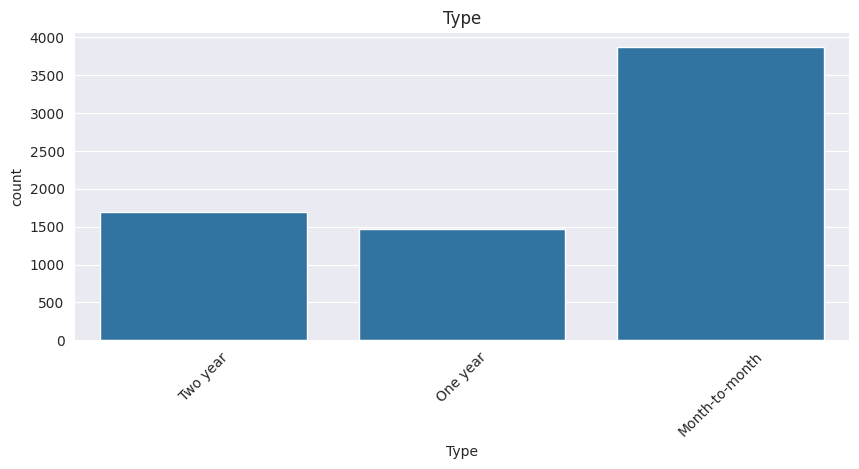

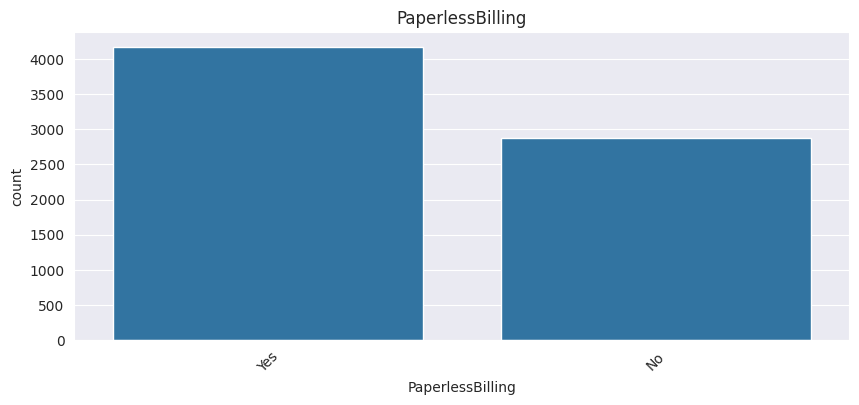

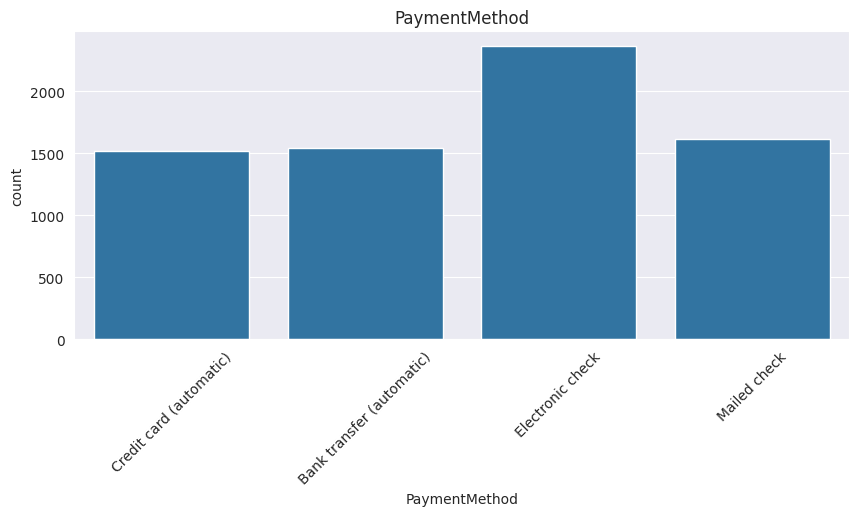

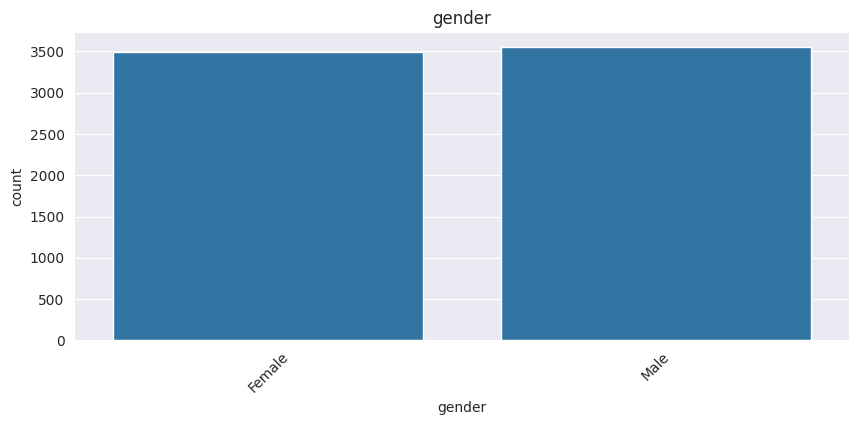

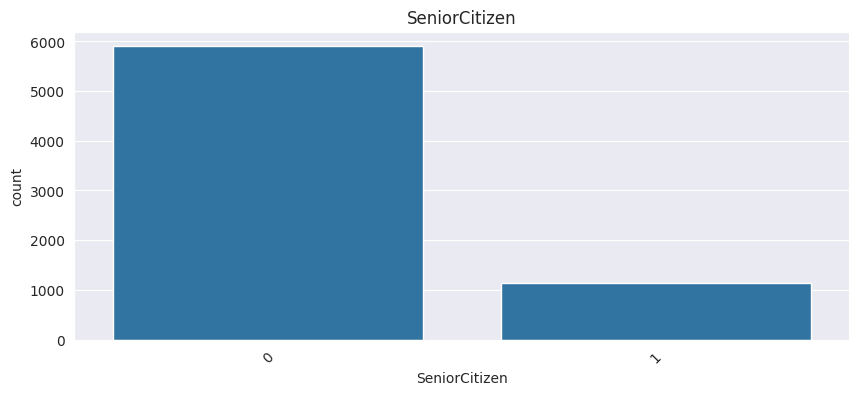

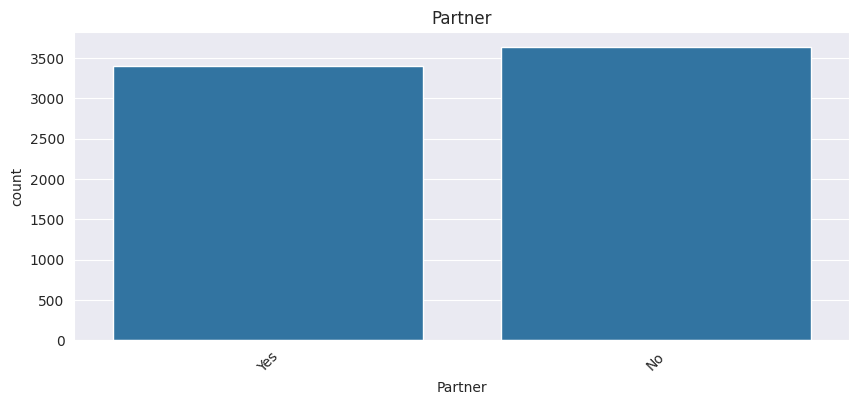

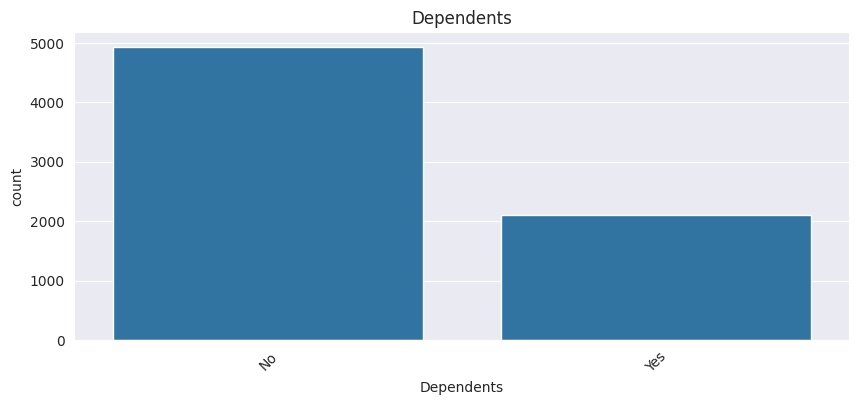

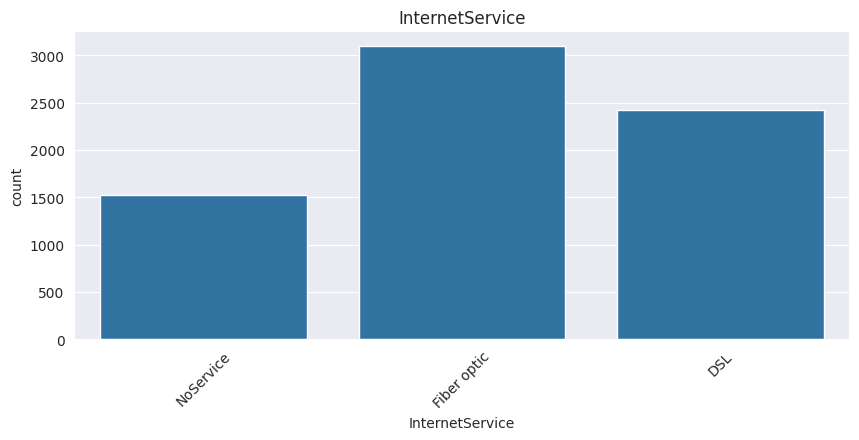

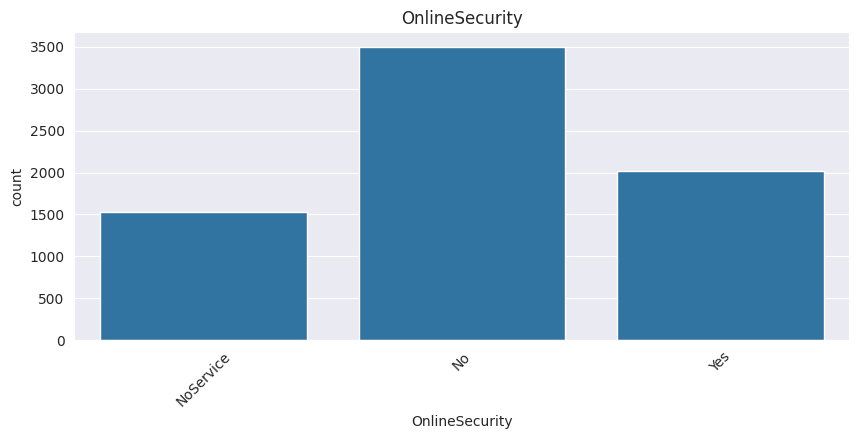

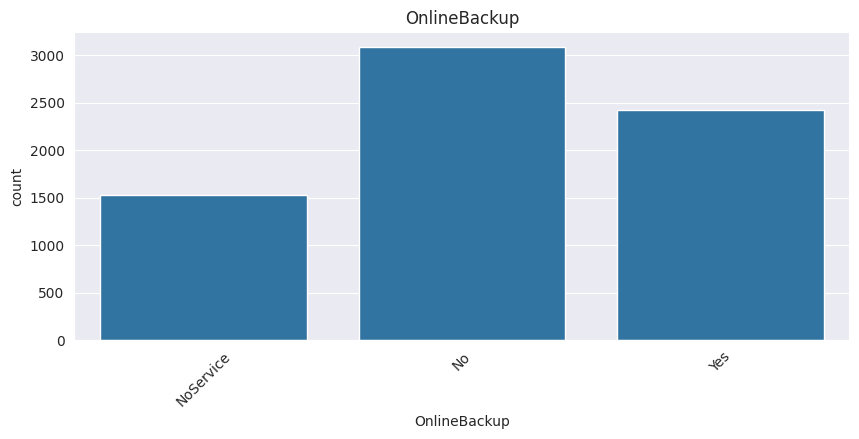

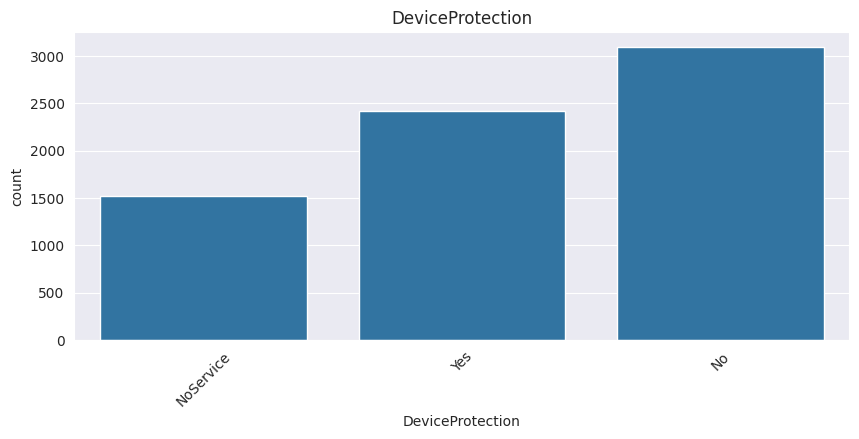

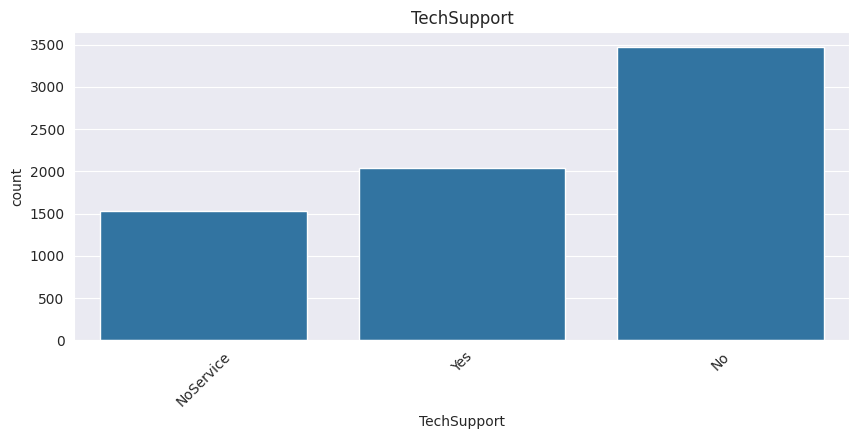

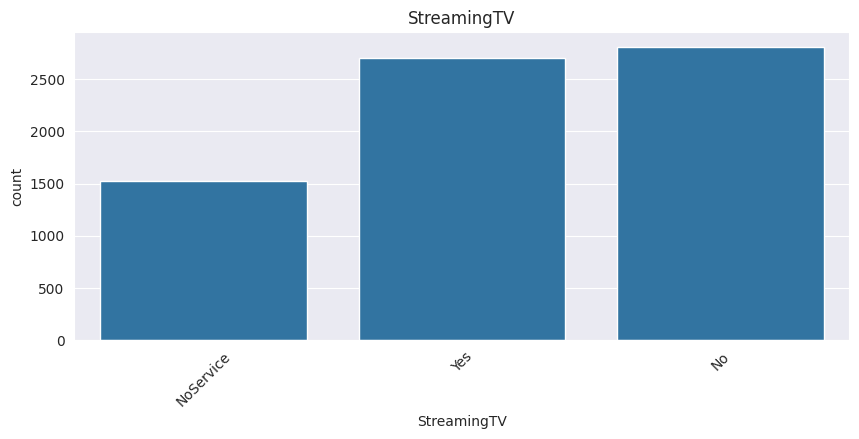

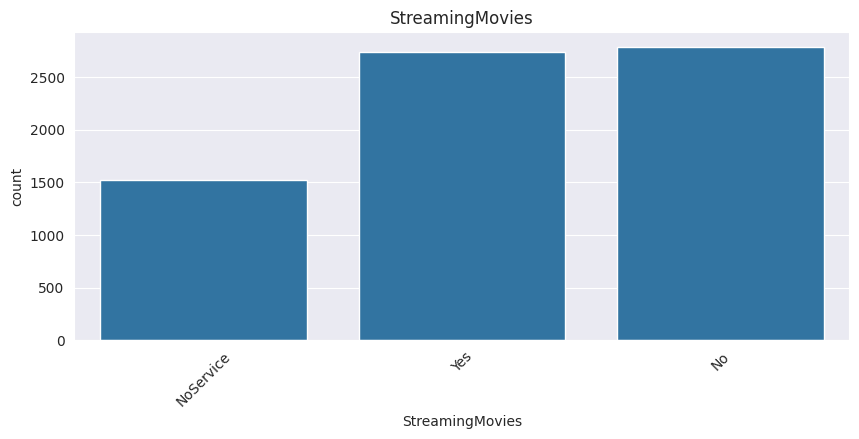

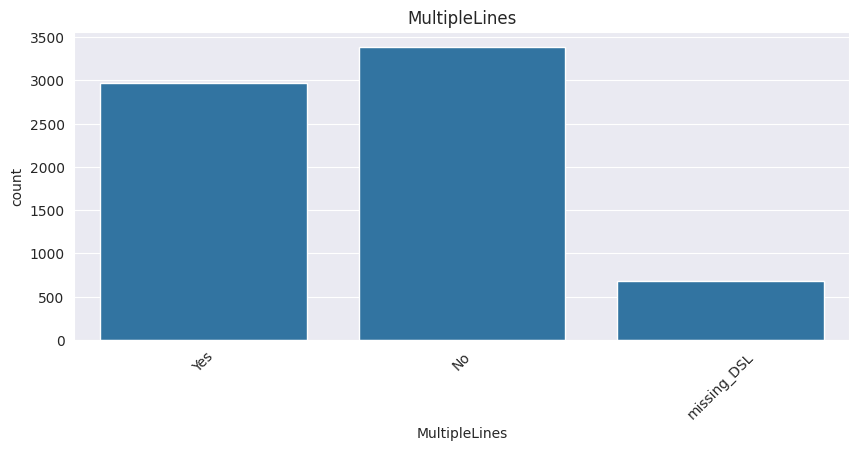

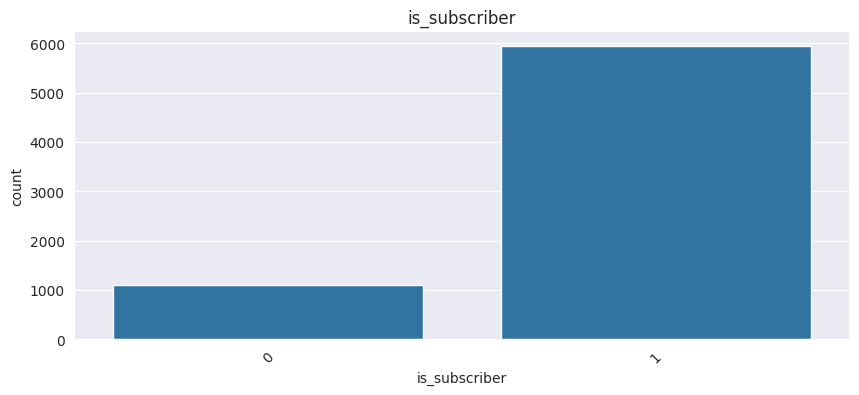

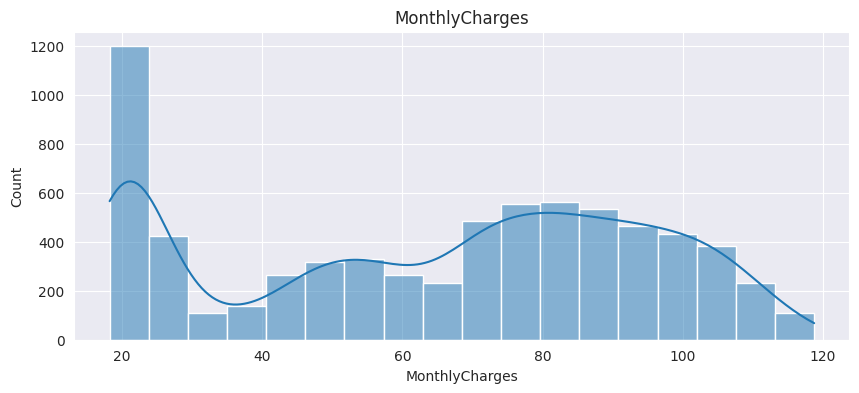

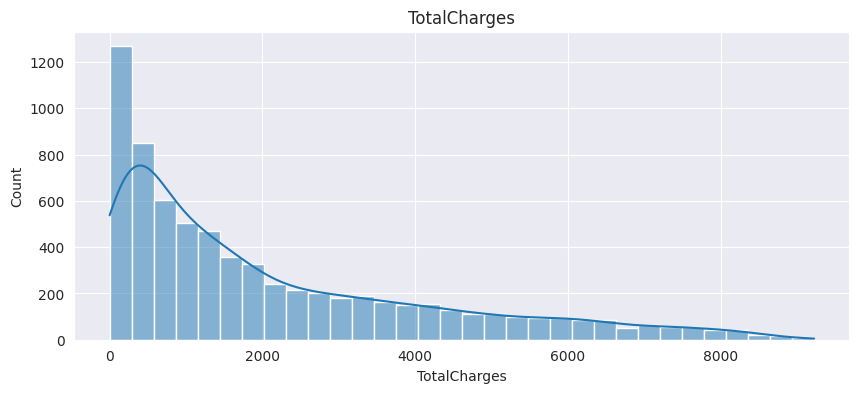

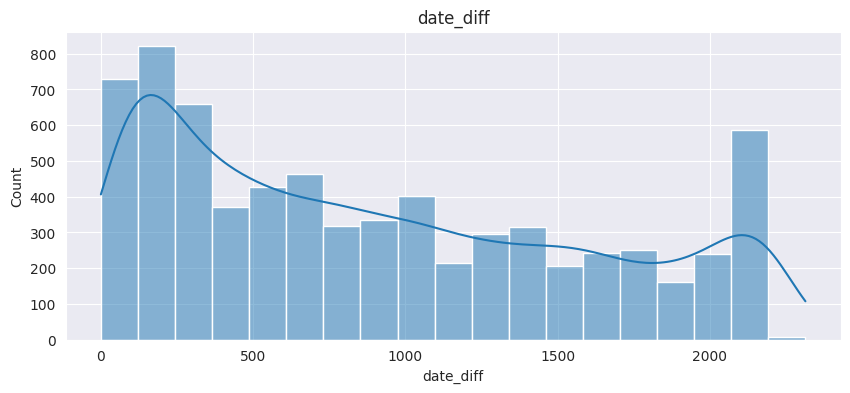

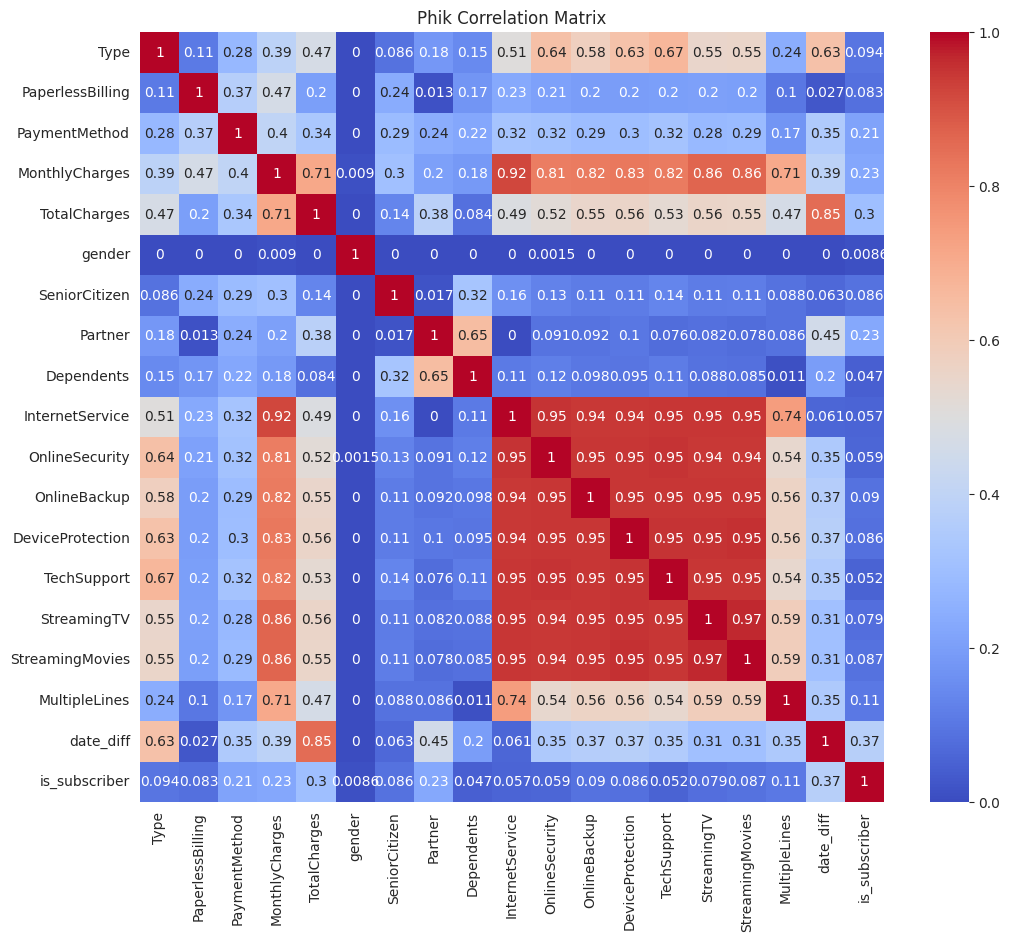

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Проверка на пропущенные значения
print("пропущенные значения")
print(merged_df.isnull().sum())

# Описательная статистика для числовых переменных
print("Описательная статистика для числовых переменных")
print(merged_df.describe())

# Функция для визуализации распределения категориальных переменных
def plot_categorical_columns(df):
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    for column in categorical_columns:
        plt.figure(figsize=(10, 4))
        sns.countplot(x=df[column].astype(str))
        plt.title(column)
        plt.xticks(rotation=45)
        plt.show()
        
# Визуализация категориальных переменных
plot_categorical_columns(merged_df)

# Функция для визуализации распределения числовых переменных
def plot_numerical_columns(df):
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
    for column in numerical_columns:
        plt.figure(figsize=(10, 4))
        sns.histplot(df[column], kde=True)
        plt.title(column)
        plt.show()

# Визуализация числовых переменных
plot_numerical_columns(merged_df)

phik_matrix = merged_df.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'date_diff'])

plt.figure(figsize=(12,10))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm')
plt.title('Phik Correlation Matrix')
plt.show()


## Подготовка данных

На этом этапе необходимо разбить данные на тренировочную и тестовую выборки, после чего закодировать категориальные признаки, нормализовать данные. Начнём с разделения на трейн и тест.

In [30]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Type              7043 non-null   object  
 1   PaperlessBilling  7043 non-null   object  
 2   PaymentMethod     7043 non-null   object  
 3   MonthlyCharges    7043 non-null   float64 
 4   TotalCharges      7043 non-null   float64 
 5   gender            7043 non-null   object  
 6   SeniorCitizen     7043 non-null   category
 7   Partner           7043 non-null   object  
 8   Dependents        7043 non-null   object  
 9   InternetService   7043 non-null   object  
 10  OnlineSecurity    7043 non-null   object  
 11  OnlineBackup      7043 non-null   object  
 12  DeviceProtection  7043 non-null   object  
 13  TechSupport       7043 non-null   object  
 14  StreamingTV       7043 non-null   object  
 15  StreamingMovies   7043 non-null   object  
 16  MultipleLines     7043 n

In [31]:
X = merged_df.drop('is_subscriber', axis=1)
y = merged_df['is_subscriber']

categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='if_binary'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111223)

## Обучение моделей машинного обучения

Создадим два пайплайна для двух моделей. В общей части у пайплайнов поместим необходимые преобразования данных,  шкалирование и импутирование. Отличаться они будут по используемой модели, один будет работать на основе случайного леса, а второй на основе модели LightGBM. Оба пайплайна будут кросс-валидированы и проверены на различных параметрах. Лучшие модели будут выявлены при помощи статистики ROC-AUC.

In [32]:
# RandomForest

# Уменьшим количество параметров что-бы уложиться в разумные сроки на сервере
# param_grid_RF = {
#     'classifier__n_estimators': [100, 200, 300],
#     'classifier__max_depth': [None, 10, 20, 30]
# }

param_grid_RF = {
    'classifier__n_estimators': [200, 300],
    'classifier__max_depth': [10, 20, 30]
}


pipeline_RF = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=111223))
])

cv_RF = ShuffleSplit(n_splits=5, test_size=0.2, random_state=111223)
grid_search_RF = GridSearchCV(pipeline_RF, param_grid_RF, cv=cv_RF,
                              scoring='roc_auc', n_jobs=-1, verbose=1)

grid_search_RF.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=111223, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore'),
                                                                         Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen',
       'Partner', 'Dependents', '...
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'MultipleLines'],
      dtype='object')),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         Index(['MonthlyCharges', 'TotalCharges', 'date_diff'], dtype='object'))])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=111223))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [10, 20, 30],
                         'classifier__n_estimators': [200, 300]},
             scoring='roc_auc', verbose=1)

<div class="alert alert-success">
<h2> Комментарий ментора <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Здорово, что используешь сочетание `ColumnTransformer` и `Pipeline` для соединения разных инструментов в единый объект - так твоё решение будет более гибким и масштабируемым. 

In [33]:
# LightGBM

# param_grid_lgbm = {
#     'lgbm__num_leaves': [31, 50, 100],
#     'lgbm__learning_rate': [0.01, 0.1, 0.3],
#     'lgbm__n_estimators': [50, 100, 200]
# }
# Очень долгий фиттинг с кросс-валидацией, поэтому была
# создана усечённая вресия параметров ниже.
# Уменьшим количество параметров
# что-бы уложиться в разумные сроки на сервере

param_grid_lgbm_slow_yandex = {
    'lgbm__num_leaves': [31, 50],
    'lgbm__learning_rate': [0.1, 0.3],
    'lgbm__n_estimators': [200]
}

pipeline_lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('lgbm', LGBMClassifier(random_state=111223))
])

cv_lgbm = ShuffleSplit(n_splits=5, test_size=0.2, random_state=111223)
grid_search_lgbm = GridSearchCV(pipeline_lgbm, param_grid_lgbm_slow_yandex, cv=cv_lgbm, 
                                scoring='roc_auc', n_jobs=-1, verbose=1)

grid_search_lgbm.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Info] Number of positive: 4763, number of negative: 871
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 768
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.845403 -> initscore=1.698991
[LightGBM] [Info] Start training from score 1.698991


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=111223, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore'),
                                                                         Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen',
       'Partner', 'Dependents', '...
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'MultipleLines'],
      dtype='object')),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         Index(['MonthlyCharges', 'TotalCharges', 'date_diff'], dtype='object'))])),
                                       ('lgbm',
                                        LGBMClassifier(random_state=111223))]),
             n_jobs=-1,
             param_grid={'lgbm__learning_rate': [0.1, 0.3],
                         'lgbm__n_estimators': [200],
                         'lgbm__num_leaves': [31, 50]},
             scoring='roc_auc', verbose=1)

## Выбор лучшей модели

In [34]:
print("Best params RandomForest:", grid_search_RF.best_params_)
print("Best Score RandomForest:", grid_search_RF.best_score_)
print("Best params LightGBM:", grid_search_lgbm.best_params_)
print("Best Score LightGBM:", grid_search_lgbm.best_score_)

Best params RandomForest: {'classifier__max_depth': 10, 'classifier__n_estimators': 300}
Best Score RandomForest: 0.821153529628743
Best params LightGBM: {'lgbm__learning_rate': 0.1, 'lgbm__n_estimators': 200, 'lgbm__num_leaves': 31}
Best Score LightGBM: 0.8853993513152391


По результатам кросс валидации и подбора параметров лучше показала себя модель LightGBM c AUC ~ 0.885. Проверим как она поведёт себя на тестовой выборке.

In [35]:
best_model = grid_search_lgbm.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
print('Accuracy', accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

Accuracy 0.8949609652235628
ROC AUC: 0.8909466386399676


In [36]:
vc = y.value_counts()
vc.name = 'Подписчики'
vc.index = ['Абоненты (Количество)', 'Прервавшие договор (Количество)']
vc['Сумма'] = vc.sum()
vc

Абоненты (Количество)              5942
Прервавшие договор (Количество)    1101
Сумма                              7043
Name: Подписчики, dtype: int64

Значения статистики не сильно отличаются от того что мы получили на тренировочной выборке. 

Метрика "accuracy" (точность) в контексте машинного обучения показывает, насколько часто модель правильно предсказывает результат. Например, если у вас есть модель, которая предсказывает, будет ли клиент использовать кредитную карту, и она правильно предсказывает 90 случаев из 100, то её точность составляет 90%.

Однако у этой метрики есть недостатки, особенно в ситуациях, когда классы данных неравномерно распределены (например, 95% клиентов не используют кредитную карту и только 5% используют). В таком случае, модель может просто предсказывать, что никто не будет использовать карту, и всё равно показать высокую точность (95%), несмотря на то, что она не способна эффективно распознавать редкие случаи использования карты. Это может привести к принятию неверных бизнес-решений.

В нашем случае метрика accuracy показывает результат в 89.4%, соотношение классов примерно 6 к 1. То есть если бы модель всегда предсказывала что абонент остается с компанией accuracy бы равнялась 5942/7043 = 0.843 или 84.3%. Результат на первый взгляд не очень впечатляющий но на не сбалансированных выборках так всегда. Тем не менее наша модель справляется лучше абсурдной.

In [37]:
# Вытащим порядок кодирования категориальных переменных, он пригодится нам в будущем
# для интерпретации результатов SHAP. Кодирование происходит по возрастающей.
best_pipeline = grid_search_lgbm.best_estimator_
encoder = best_pipeline.named_steps['preprocessor'].named_transformers_['cat']
categories = encoder.categories_
print(categories)

[array(['Month-to-month', 'One year', 'Two year'], dtype=object), array(['No', 'Yes'], dtype=object), array(['Bank transfer (automatic)', 'Credit card (automatic)',
       'Electronic check', 'Mailed check'], dtype=object), array(['Female', 'Male'], dtype=object), array([0, 1]), array(['No', 'Yes'], dtype=object), array(['No', 'Yes'], dtype=object), array(['DSL', 'Fiber optic', 'NoService'], dtype=object), array(['No', 'NoService', 'Yes'], dtype=object), array(['No', 'NoService', 'Yes'], dtype=object), array(['No', 'NoService', 'Yes'], dtype=object), array(['No', 'NoService', 'Yes'], dtype=object), array(['No', 'NoService', 'Yes'], dtype=object), array(['No', 'NoService', 'Yes'], dtype=object), array(['No', 'Yes', 'missing_DSL'], dtype=object)]


Рассмотрим матрицу ошибок.

In [38]:
cm = confusion_matrix(y_test, y_pred)

print('true_negatives_abs :', true_negatives_abs  := cm[0, 0])
print('false_positives_abs:', false_positives_abs := cm[0, 1])
print('false_negatives_abs:', false_negatives_abs := cm[1, 0])
print('true_positives_abs :', true_positives_abs  := cm[1, 1])

true_negatives_abs : 112
false_positives_abs: 118
false_negatives_abs: 30
true_positives_abs : 1149


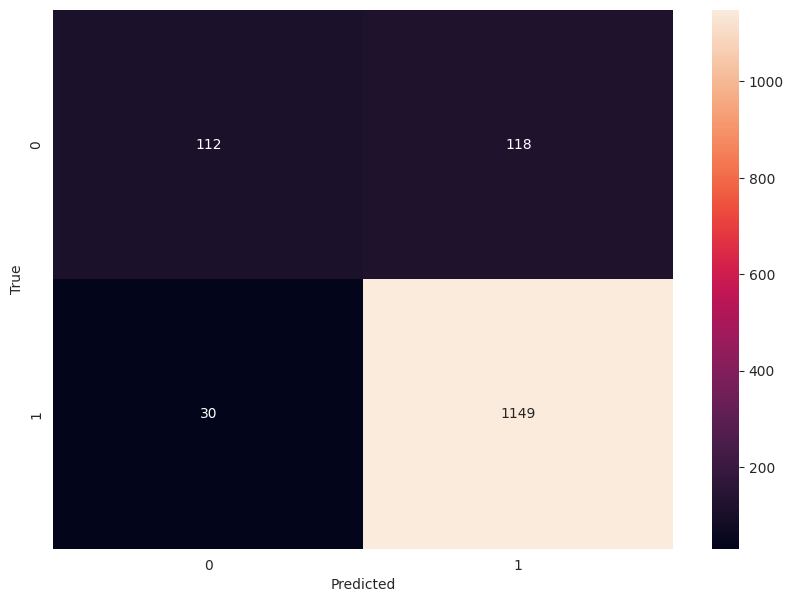

In [39]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

В абсолютных значениях матрица ошибок выглядит не плохо. Истинно-положительных значений на порядок больше чем всех остальных. Маловато конечно истинно-отрицательных результатов, для соотношения 6 к 1 в классах их должно быть побольше. Для упрощения анализа рассмотрим нормализованную матрицу ошибок.

In [40]:
cm = confusion_matrix(y_test, y_pred, normalize='true')

print('true_negatives_rel :', true_negatives_rel  := cm[0, 0])
print('false_positives_rel:', false_positives_rel := cm[0, 1])
print('false_negatives_rel:', false_negatives_rel := cm[1, 0])
print('true_positives_rel :', true_positives_rel  := cm[1, 1])

true_negatives_rel : 0.48695652173913045
false_positives_rel: 0.5130434782608696
false_negatives_rel: 0.02544529262086514
true_positives_rel : 0.9745547073791349


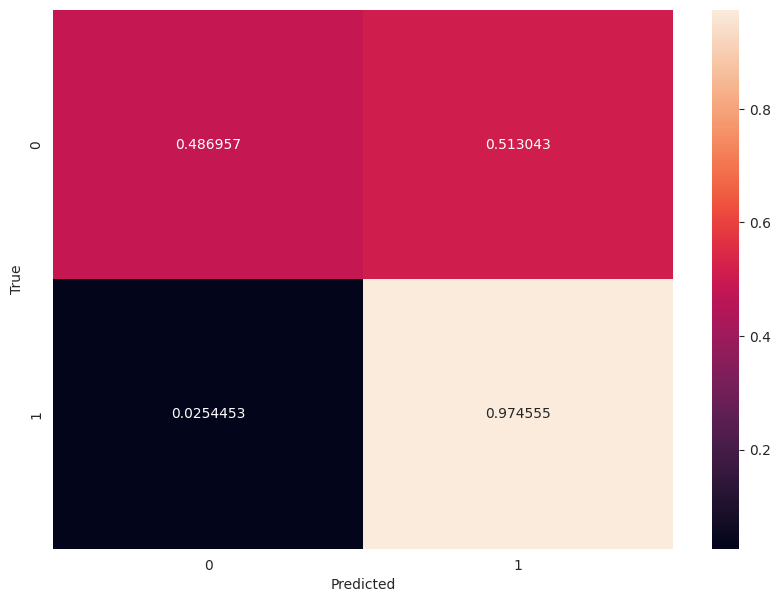

In [41]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Эта матрица выглядит более информативно. В целом мы предсказываем истинно отрицательный(человек ушел из компании) и ложно положительный(человек ушел, но мы говорим что остался) результаты в половине случаев. Случаев когда мы говорим что человек остался, но он на самом деле ушел практически нет, чуть более двух процентов. И наконец для истинно положительных результатов(человек остался в компании) мы правы в 98.2 случаев.

In [42]:
# Поскольку с пайплайнами ШАП работать отказался, я решил попробовать натренировать модель заново.
model = LGBMClassifier(random_state=111223, learning_rate=0.3, n_estimators=200, num_leaves=31)
X_train_transformed = preprocessor.fit_transform(X_train, y_train)
X_train_transformed = pd.DataFrame(X_train_transformed, 
                                   columns=list(preprocessor.get_feature_names_out()))
model.fit(X_train_transformed, y_train)
X_test_transformed = preprocessor.transform(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4763, number of negative: 871
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 768
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.845403 -> initscore=1.698991
[LightGBM] [Info] Start training from score 1.698991


 99%|===================| 5602/5634 [00:48<00:00]        

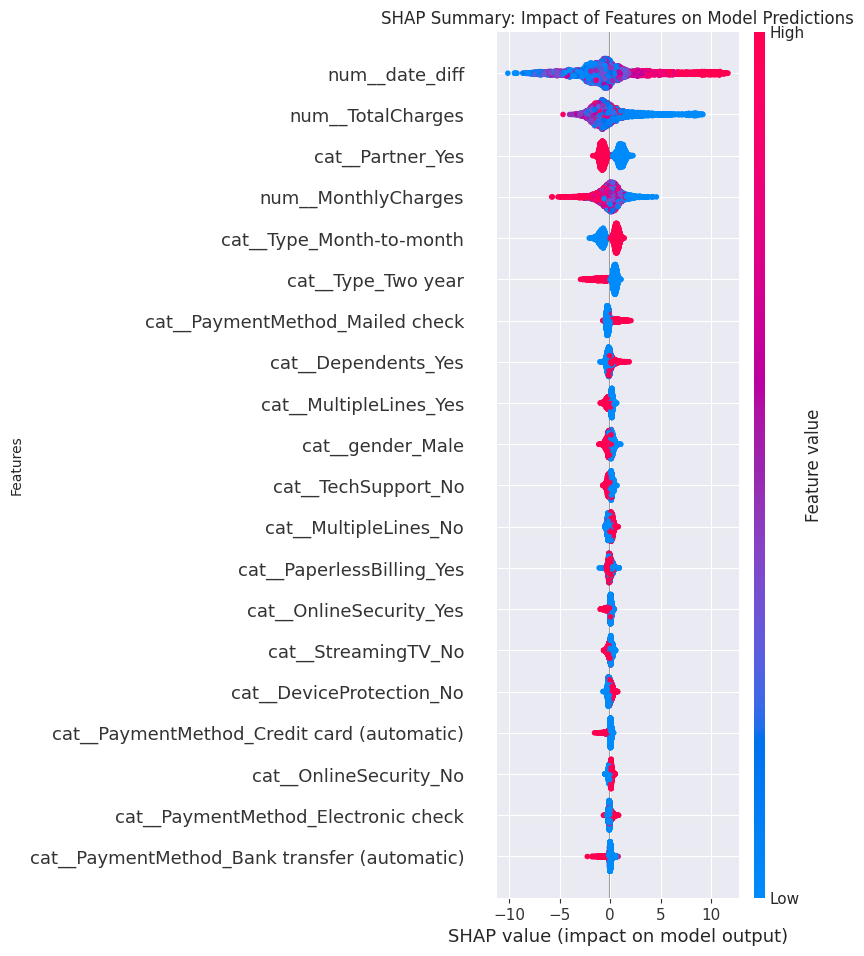

In [43]:
explainer = shap.TreeExplainer(model, X_train_transformed)
shap_values = explainer(X_train_transformed)
shap.summary_plot(shap_values, X_train_transformed, show=False)
plt.title("SHAP Summary: Impact of Features on Model Predictions")
plt.ylabel("Features")
plt.show()

__Интерпретация SHAP__: Наиболее значимым признаком является количество дней с компанией. Чем больше дней тем меньше лояльность. На втором месте TotalCharges, чем меньше денег заплатил клиент за всё время, тем больше вероятность того что он расторгнет договор. На третьем месте наличие партнера, при наличии партнера вероятность разрыва договора снижается, для одиноких людей верно обратное.

## Общий вывод и рекомендации заказчику

В результате работы был произведён анализ пользовательских данных оператора связи "ТелеДом". Даные были предобработаны, проверены на дубли, очищены от артефактов и приведены к правильным типам данных. Также данные были охарактеризованы с частотной стороны, что помогло составить представление о наборе данных. После чего данные были объединены по полю customerID левым джоином от таблицы contract_new, что позволило получить примерно 7 тысяч строк после объединения.

Следующим этапом стало избавление от столбцов усложняющих работу с датасетом, тем не менее несущих полезную информацию. Это столбцы с датами заключения договора и его расторжения(если есть). На их основе было сделано два столбца, один показывает количество дней которые абонент провел с компанией, а второй является целевым и принимает значения 1/0 в зависимости от того является ли на данный момент клиент абонентом, или уже расторгнул договор. Его мы и предсказываем.

Также данные были перекодированы в 1/0 бинарный формат, шкалированы и импутированы методом К ближайших соседей по необходимости.

__Выводы для заказчика__: 

Точность модели составила 90 процентов, но к этой цифре надо относится с осторожностью поскольку у нас есть сильный дисбалланс классов между абонентами и ушедшими, примерно 6 к 1. Тем не менее с некоторой вероятностью мы можем предсказать когда человек соберётся расторгнуть договор так как значение accuracy полученное нами на 5% выше чем у абсурдной модели которая всегда предсказывает что клиент останется с компанией.

В целом мы предсказываем истинно отрицательный(человек ушел из компании) и ложно положительный(человек ушел, но мы говорим что остался) результаты в половине случаев. Случаев когда мы говорим что человек остался, но он на самом деле ушел практически нет, чуть более одного процента. И наконец для истинно положительных результатов(человек остался в компании) мы правы в 98.2 случаев.

Наиболее значимым признаком намерения расторгнуть количество дней в компании, чем дольше человек пользуется услугами компании тем вероятнее он расторгнет договор. Общие расходы также оказывают влияние на вероятность расторжения договора, как ни странно люди платящие максимальные и минимальные суммы не склонны разрывать договор, это делают в основном люди которые тратят чуть выше среднего. Странность также есть в том что абоненты с месячным расходом выше среднего не склонны разрывать договор, тогда как абоненты с низкими расходами в месяц наоборот. Люди с высоким ежемесячным счётом гораздо реже разрывают договор, по сравнению с теми у кого ежемесячный платёж низкий.